## This notebook contains code to easily create the inputs required to run the process in one of the 'overlay' notebooks.

#### In addition to the outputs produced by this output, the user will need to also obtain from other sources elevation (NED DEM) and optionally ortho imagery data (NAIP).  

#### The final steps in the process is done in manually ArcScene outside of this notebook.  See instructions at the bottom of this notebook.

The bulk of the libraries required for this processing can be found in the ../environment.yml file
A conda env can be created with:
conda env create -f environment.yml

But there were two libraries used that are either not yet up on conda or pip, or need a version latter than what's available:
These are ulmo 0.8.3dev, available from:
https://github.com/ulmo-dev/ulmo/tree/master/ulmo
and:
landsat-util 0.13.0 which is available on pypi but I had to install manually:
https://pypi.python.org/pypi/landsat-util/0.13.0

The only data not automatically downloaded are the MODIS layers which are accessed from a local repository.

Given the non-standard libraries and local data requirements, this notebook should be considered comprehensive documentation of the process used to produce the inputs for this analysis, instead of a tool/script to be run by a general, non-expert users.

In [2]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

import rasterio

In [3]:
import sys
sys.path.append(r"..\..")
import pyphenocam

sys.path.append(r"J:\Projects\NCCSC\phenocam\Tools\DaymetPy\daymetpy")
import daymetpy

# Create a point shapefile of our camera location

In [4]:
output_dir = r"J:\Projects\NCCSC\phenocam\DerivedData\quickbird"
site_name = "quickbird"

In [5]:
site = pyphenocam.dataaccess.get_site(site_name)

In [6]:
site.x, site.y

(-109.30386999999999, 41.928871)

In [7]:
import fiona
from fiona.crs import from_epsg
from shapely.geometry import Point, mapping

In [8]:
simpleschema = {'geometry': 'Point',
               'properties': {'name':'str'}}
wgs84_dir = os.path.join(output_dir, "wgs84")
if not os.path.exists(wgs84_dir):
    os.makedirs(wgs84_dir)
camera_fname = os.path.join(wgs84_dir, "cameraloc.shp")
with fiona.open(camera_fname, 'w', crs=from_epsg(4326),driver='ESRI Shapefile', schema=simpleschema) as output:
    point = Point(site.x, site.y)
    output.write({'properties': {'name': site.sitename},'geometry': mapping(point)})

# Download the landsat8 scene over this area

In [9]:
from landsat.search import Search
from landsat.downloader import Downloader

In [10]:
s = Search()
results = s.search(lat=site.y, lon=site.x, limit=100)
scene_id = results['results'][1]['sceneID']

In [11]:
landsat_dname = os.path.join(output_dir, 'Landsat')
if not os.path.exists(landsat_dname):
    os.makedirs(landsat_dname)


In [11]:
from landsat.downloader import Downloader
d = Downloader(download_dir=landsat_dname)
result = d.download([str(scene_id)])

     0%    620 Bytes     620 Bytes/s   15 days, 7:14:44 ETA    


===> Source: Google Storge
===> Downloading: LC80370312015207LGN00.tar.bz


     0%    943.6 KiB     628.6 KiB/s            0:21:11 ETA    
     0%      2.1 MiB       1.0 MiB/s            0:12:39 ETA    
     0%      3.2 MiB       1.3 MiB/s            0:10:06 ETA    
     0%      4.2 MiB       1.4 MiB/s            0:09:16 ETA    
     0%      4.8 MiB       1.4 MiB/s            0:09:30 ETA    
     0%      5.7 MiB       1.4 MiB/s            0:09:07 ETA    
     0%      6.6 MiB       1.4 MiB/s            0:08:55 ETA    
     0%      7.6 MiB       1.5 MiB/s            0:08:34 ETA    
     1%      8.7 MiB       1.6 MiB/s            0:08:14 ETA    
     1%      9.7 MiB       1.6 MiB/s            0:08:00 ETA    
     1%     10.8 MiB       1.6 MiB/s            0:07:48 ETA    
     1%     11.9 MiB       1.7 MiB/s            0:07:36 ETA    
     1%     12.7 MiB       1.7 MiB/s            0:07:36 ETA    
     1%     13.8 MiB       1.7 MiB/s            0:07:27 ETA    
     1%     14.8 MiB       1.7 MiB/s            0:07:22 ETA    
     2%     15.9 MiB       1.8 MiB/s    

     stored at J:\Projects\NCCSC\phenocam\DerivedData\quickbird\Landsat


In [12]:
import tarfile
scene_dname = os.path.join(landsat_dname, scene_id)
tar_fname = os.path.join(landsat_dname, scene_id + ".tar.bz")
tar = tarfile.open(tar_fname)
tar.extractall(path=scene_dname)
tar.close()

os.unlink(tar_fname)

In [12]:
from pygaarst import raster
scene_dname = os.path.join(landsat_dname, scene_id)
sc = raster.Landsatscene(scene_dname)

In [13]:
scene_dname = os.path.join(landsat_dname, scene_id)
scene_dname
b4_fname = os.path.join(scene_dname, [f for f in os.listdir(scene_dname) if f.endswith('_B4.TIF')][0])
b5_fname = os.path.join(scene_dname, [f for f in os.listdir(scene_dname) if f.endswith('_B5.TIF')][0])

In [14]:
landsat = rasterio.open(b5_fname)
landsat_data = landsat.read(masked=True)

landsat_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]

#### If the location isn't good either get another landsat scene or mosaic a couple

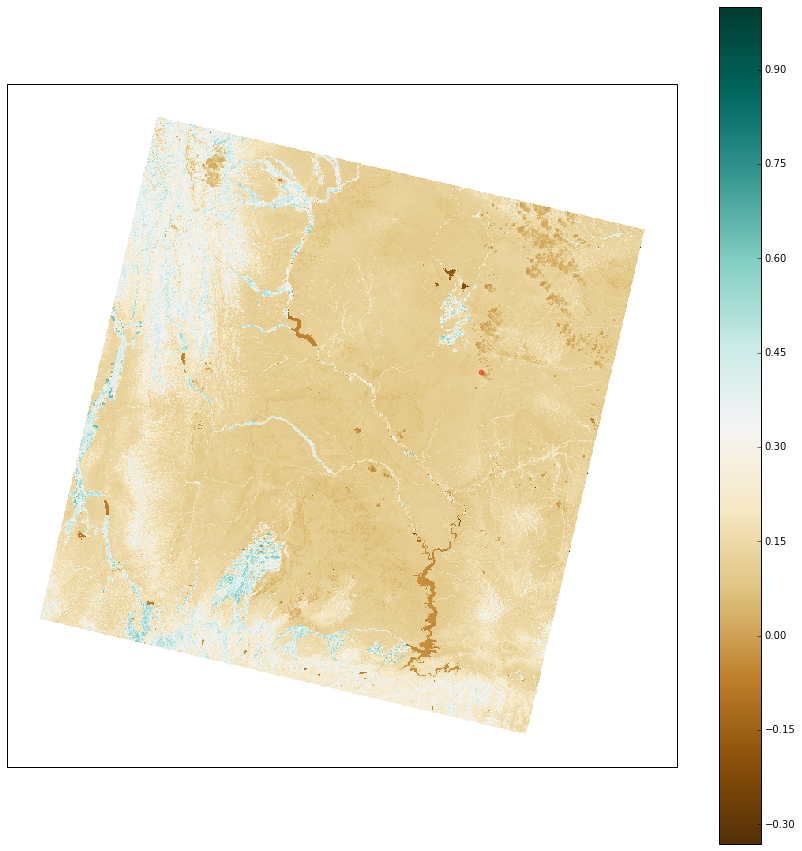

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


utm_zone = landsat.crs_wkt.split('UTM zone ')[1].split('N"')[0]
landsat_proj = ccrs.UTM(zone=utm_zone, globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))

fig = plt.figure(figsize=(15, 15))
# ax_extent = [quickbird.x - 0.015, quickbird.x + 0.015, quickbird.y - 0.002, quickbird.y + 0.015]

ax = plt.axes(projection=landsat_proj)
# ax.set_extent(ax_extent, ccrs.Geodetic())
im = ax.imshow(sc.NDVI[::10, ::10], origin='upper', extent=landsat_extents, 
          transform=landsat_proj, interpolation='none', cmap=mpl.cm.BrBG)

geodetic = ccrs.Geodetic()
ax.scatter(site.x, site.y, color='r', s=20, alpha=0.5, transform=geodetic)

plt.colorbar(im)

### We need to extract out a subset 254x254 centered horizontally on our camera loc, and extending north

In [16]:
landsat_camx, landsat_camy = list(landsat_proj.transform_point(site.x, site.y, geodetic))
landsat_camx, landsat_camy

(640628.0142858622, 4643269.998228128)

In [17]:
landsat_a = landsat.affine

In [18]:
import math
landsat_cam_col, landsat_cam_row = [int(math.floor(coord)) for coord in ~landsat_a * (landsat_camx, landsat_camy)]
landsat_left_col, landsat_right_col = landsat_cam_col-254/2, landsat_cam_col+254/2
landsat_upper_row, landsat_lower_row = landsat_cam_row-244, landsat_cam_row+10

print landsat_cam_col, landsat_cam_row
print landsat_left_col, landsat_right_col
print landsat_upper_row, landsat_lower_row

5604 3254
5477 5731
3010 3264


In [19]:
landsat_ulx, landsat_uly = landsat_a * (landsat_left_col, landsat_upper_row)
landsat_lrx, landsat_lry = landsat_a * (landsat_right_col, landsat_lower_row)
landsat_urx, landsat_ury = landsat_a * (landsat_right_col, landsat_upper_row)
landsat_llx, landsat_lly = landsat_a * (landsat_left_col, landsat_lower_row)

print landsat_ulx, landsat_uly
print landsat_lrx, landsat_lry
print landsat_urx, landsat_ury
print landsat_llx, landsat_lly


print landsat_camx, landsat_camy

636795.0 4650615.0
644415.0 4642995.0
644415.0 4650615.0
636795.0 4642995.0
640628.014286 4643269.99823


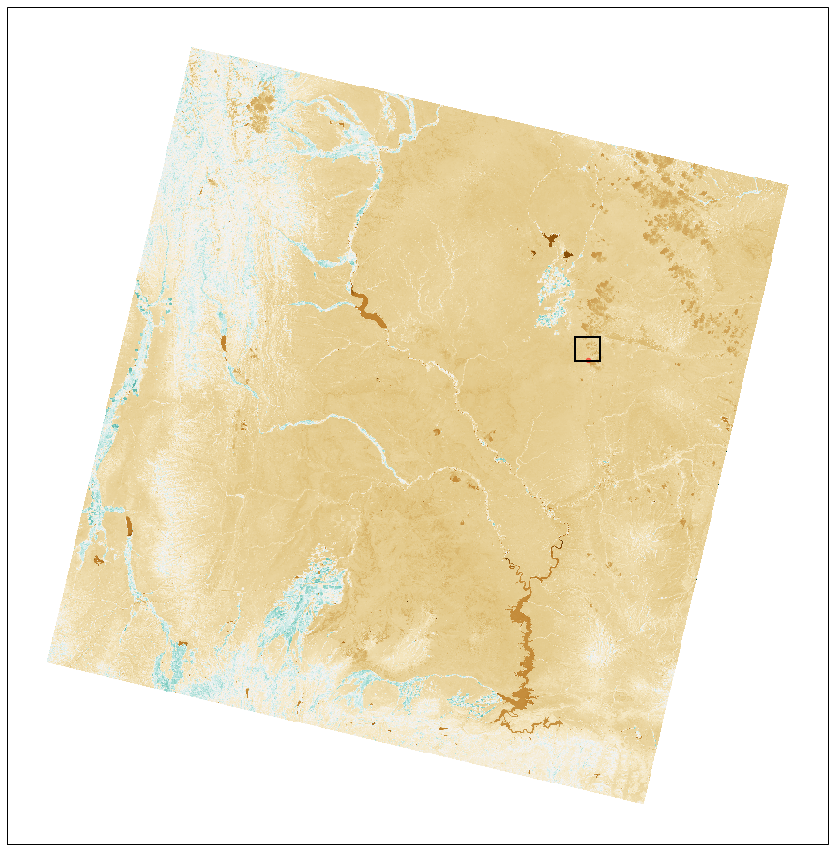

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=landsat_proj)
ax.imshow(sc.NDVI[::10, ::10], origin='upper', extent=landsat_extents, 
          transform=landsat_proj, interpolation='none', cmap=mpl.cm.BrBG)

ax.scatter(site.x, site.y, color='r', s=20, alpha=0.5, transform=geodetic)

ax.plot([landsat_ulx, landsat_lrx], [landsat_uly, landsat_uly], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([landsat_ulx, landsat_lrx], [landsat_lry, landsat_lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([landsat_ulx, landsat_ulx], [landsat_uly, landsat_lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([landsat_lrx, landsat_lrx], [landsat_uly, landsat_lry], 'k-', lw=2, c='black', transform=landsat_proj)


In [21]:
from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
poly = Polygon([(landsat_ulx, landsat_uly), 
                (landsat_lrx, landsat_uly), 
                (landsat_lrx, landsat_lry), 
                (landsat_ulx, landsat_lry), 
                (landsat_ulx, landsat_uly)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
landsat_subset_dname = os.path.join(landsat_dname, 'Subset')
if not os.path.exists(landsat_subset_dname):
    os.makedirs(landsat_subset_dname)
    
boundary_fname = os.path.join(landsat_subset_dname, 'landsat_boundary.shp')
with fiona.open(boundary_fname, 'w', 'ESRI Shapefile', schema, crs=landsat.crs) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(poly),
        'properties': {'id': 123},
    })

In [22]:
from shapely.geometry import mapping, Polygon
import fiona

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'row': 'int', 'col':'int'},
}

# Write a new Shapefile
landsat_subset_dname = os.path.join(landsat_dname, 'Subset')
if not os.path.exists(landsat_subset_dname):
    os.makedirs(landsat_subset_dname)
    
fishnet_fname = os.path.join(landsat_subset_dname, 'landsat_fishnet.shp')
with fiona.open(fishnet_fname, 'w', 'ESRI Shapefile', schema, crs=landsat.crs) as c:
    ## If there are multiple geometries, put the "for" loop here
    for row in range(254):
        cell_uly = landsat_uly + (row*landsat_a.e)
        for col in range(254):
            cell_ulx = landsat_ulx + (col*landsat.affine.a)
            poly = Polygon([(cell_ulx, cell_uly), 
                            (cell_ulx + landsat_a.a, cell_uly), 
                            (cell_ulx + landsat_a.a, cell_uly + landsat_a.e), 
                            (cell_ulx, cell_uly + landsat_a.e), 
                            (cell_ulx, cell_uly)])
    
    
            c.write({
                'geometry': mapping(poly),
                'properties': {'row': row,
                              'col':col},
            })

# Create a subset of this for display purposes

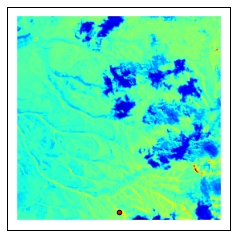

In [55]:
landsat_subset = sc.NDVI[ 
                landsat_upper_row:landsat_lower_row, 
                landsat_left_col:landsat_right_col]
plt.imshow(landsat_subset)
plt.scatter(landsat_cam_col-landsat_left_col, landsat_cam_row-landsat_upper_row, c='r')
pyphenocam.plotting.format_photo_axes(plt.gca())

In [65]:
landsat_subset_fname = os.path.join(landsat_subset_dname, "landsat_subset.tif")

import copy
landsat_subset_meta = copy.copy(landsat.meta)
landsat_subset_meta['width'] = landsat_subset.shape[0]
landsat_subset_meta['height'] = landsat_subset.shape[1]

new_transform = list(landsat.meta['transform'])
new_transform[0] = landsat_ulx
new_transform[3] = landsat_uly
landsat_subset_meta['transform'] = tuple(new_transform)
landsat_subset_meta['dtype'] = 'float32'
import affine
landsat_subset_meta['affine'] = affine.Affine.from_gdal(*landsat_subset_meta['transform'])
with rasterio.open(landsat_subset_fname, 'w', **landsat_subset_meta) as dst:
    dst.write_band(1, landsat_subset.astype(rasterio.float32))


In [60]:
landsat_subset_meta

{'affine': Affine(30.0, 0.0, 636795.0,
       0.0, -30.0, 4650615.0),
 'count': 1,
 'crs': {'init': u'epsg:32612'},
 'driver': u'GTiff',
 'dtype': 'uint16',
 'height': 254L,
 'nodata': None,
 'transform': (636795.0, 30.0, 0.0, 4650615.0, 0.0, -30.0),
 'width': 254L}

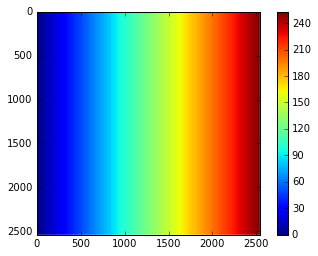

In [25]:
%matplotlib inline
n=10
r = np.zeros(landsat_subset.shape).astype(np.dtype('i1'))
landsat_col_x3 = np.tile(np.repeat(np.arange(r.shape[1]), n), (r.shape[0])*n)
landsat_col_x3.shape = r.shape[0]*n, r.shape[1]*n

plt.imshow(landsat_col_x3, interpolation='none')
plt.colorbar()


In [26]:
landsat_col_x3.shape

(2540L, 2540L)

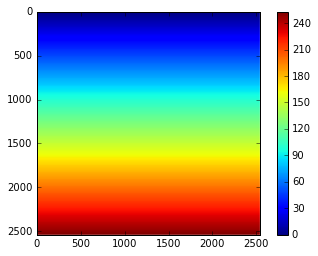

In [27]:
landsat_row_x3 = np.tile(np.repeat(np.arange(r.shape[0]), n), (r.shape[1]*n))
landsat_row_x3.shape = r.shape[1]*n, r.shape[0]*n
landsat_row_x3 = landsat_row_x3.T

plt.imshow(landsat_row_x3, interpolation='none')
plt.colorbar()


In [28]:
landsat_b = np.zeros(landsat_row_x3.shape)

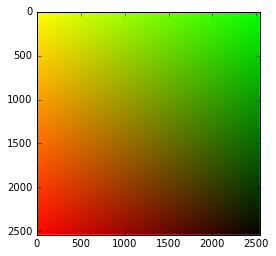

In [29]:
%matplotlib inline
plt.imshow(np.dstack([landsat_col_x3, landsat_row_x3, landsat_b])[:,:,:], interpolation='none')


##### One small detail to note, because of the way ArcScene renders a raster, we're increasing the pixel  resoultion 10x

In [30]:
import scipy
subset_index_fname = os.path.join(landsat_subset_dname, "landsat_subset_index.tif")

import copy
landsat_subset_meta = copy.copy(landsat.meta)
landsat_subset_meta['width'] = landsat_subset.shape[0] * 10
landsat_subset_meta['height'] = landsat_subset.shape[1] * 10

new_transform = list(landsat.meta['transform'])
new_transform[0] = landsat_ulx
new_transform[3] = landsat_uly
new_transform[1] = new_transform[1] / 10.0
new_transform[-1] = new_transform[-1] / 10.0
landsat_subset_meta['transform'] = new_transform

import affine
landsat_subset_meta['affine'] = affine.Affine.from_gdal(*landsat_subset_meta['transform'])

landsat_subset_meta.update(
    dtype=rasterio.uint8,
    count=3,
    nodata=255)

with rasterio.open(subset_index_fname, 'w', **landsat_subset_meta) as dst:
    dst.write_band(1, landsat_col_x3.astype(rasterio.uint8))
    dst.write_band(2, landsat_row_x3.astype(rasterio.uint8))
    dst.write_band(3, landsat_b.astype(rasterio.uint8))

## download and process some NED 30m DEM data for our area

In [31]:
from ulmo.usgs.ned import core
core.get_available_layers()

['1 arc-second', '1/9 arc-second', 'Alaska 2 arc-second', '1/3 arc-second']

In [33]:
layer = '1/3 arc-second'
landsat_bbox = list(geodetic.transform_point(landsat_ulx, landsat_lry, landsat_proj))
landsat_bbox += list(geodetic.transform_point(landsat_lrx, landsat_uly, landsat_proj))
dname = os.path.join(output_dir, "ArcScene", "InputData", "DEM")
if not os.path.exists(dname):
    os.makedirs(dname)
dem_result = core.get_raster(layer=layer, bbox=landsat_bbox, path=dname, mosaic=True)

retrieving raster availability from https://www.sciencebase.gov/catalog/items?fields=webLinks,spatial,title&q=&filter=tags=National Elevation Dataset (NED) 1/3 arc-second&filter=tags=IMG&filter=spatialQuery=Polygon ((-109.35014545002137 41.99431110321043,-109.35014545002137 41.9270686877429,-109.25641258938867 41.9270686877429,-109.25641258938867 41.99431110321043,-109.35014545002137 41.99431110321043))&format=json&max=1000
... downloading tile 1 of 1 from https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/n42w110.zip
... ... zipfile saved at J:\Projects\NCCSC\phenocam\DerivedData\quickbird\ArcScene\InputData\DEM\13\zip\n42w110.zip
... ... .img format raster saved at J:\Projects\NCCSC\phenocam\DerivedData\quickbird\ArcScene\InputData\DEM\13\n42w110.img


## Reproject this to match our landsat subset grid

In [34]:
if type(dem_result) == list:
    dem_result = dem_result[0]

In [35]:
dem = rasterio.open(dem_result)
landsat_subset = rasterio.open(landsat_subset_fname)

In [36]:
from rasterio.warp import calculate_default_transform, reproject, RESAMPLING

utm_dname = os.path.join(output_dir, "ArcScene", "InputData", "UTM")
if not os.path.exists(utm_dname):
    os.makedirs(utm_dname)
    
out_fname = os.path.join(utm_dname, "NED_30m.tif")
# affine, width, height = calculate_default_transform(
#     src.crs, dst_crs, src.width, src.height, *src.bounds)
kwargs = landsat_subset.meta.copy()
kwargs['dtype'] = dem.meta['dtype']
kwargs['nodata'] = -9999
# kwargs.update({
#         'crs': subset.crs,
#         'transform': subset.affine,
#         'affine': subset.affine,
#         'width': subset.width,
#         'height': subset.height
#     })

with rasterio.open(out_fname, 'w', **kwargs) as dst:
    reproject(
        source=rasterio.band(dem, 1),
        destination=rasterio.band(dst, 1),
        src_transform=dem.affine,
        src_crs=dem.crs,
        src_nodata=kwargs['nodata'],
        dst_transform=landsat_subset.affine,
        dst_crs=landsat_subset.crs,
        dst_nodata=kwargs['nodata'],
        resampling=RESAMPLING.cubic_spline)

    

    dem_data = dst.read_band(1, masked=True)   


C:\Anaconda\envs\pyphenocam\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: read_band() is deprecated and will be removed by Rasterio 1.0. Please use read() instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


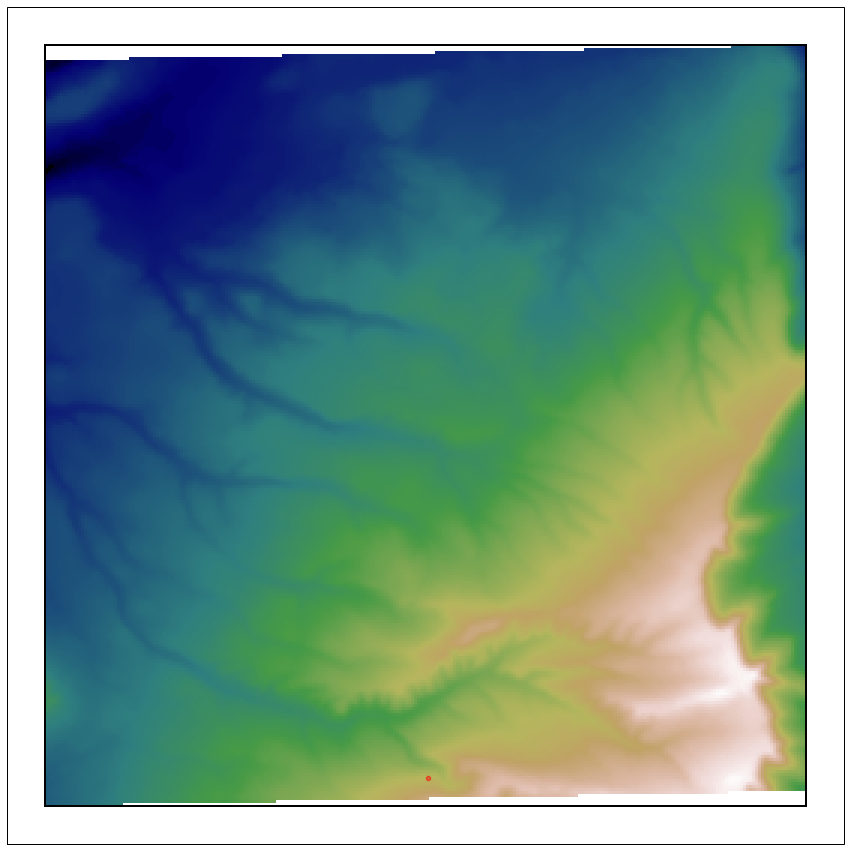

In [37]:
elev_subset_fname = out_fname
elev = rasterio.open(elev_subset_fname)
elev_data = elev.read()

nad83 = ccrs.Geodetic(globe=ccrs.Globe(datum='NAD83', ellipse='GRS80'))

elev_extents = [elev.bounds.left, elev.bounds.right, elev.bounds.bottom, elev.bounds.top]


fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=landsat_proj)
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none')

ax.scatter(site.x, site.y, color='r', s=20, alpha=0.5, transform=geodetic)

ax.plot([landsat_ulx, landsat_lrx], [landsat_uly, landsat_uly], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([landsat_ulx, landsat_lrx], [landsat_lry, landsat_lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([landsat_ulx, landsat_ulx], [landsat_uly, landsat_lry], 'k-', lw=2, c='black', transform=landsat_proj)
ax.plot([landsat_lrx, landsat_lrx], [landsat_uly, landsat_lry], 'k-', lw=2, c='black', transform=landsat_proj)

# And do the same thing we did with landsat for modis (250m)

We have some nationwide mosaics of the 250m modis products maintained at the fort collins science center.  TODO:add link to notbook used to generate these...

In [38]:
modis_mosaic_fname = r"J:\GIS_Layers\Climate\ClimateCache\MODIS\DerivedData\Mosaics\NDVI\MOD13Q1.A2001081.NDVI.tif"
modis_mosaic = rasterio.open(modis_mosaic_fname)
modis_mosaic_data = modis_mosaic.read(masked=True)

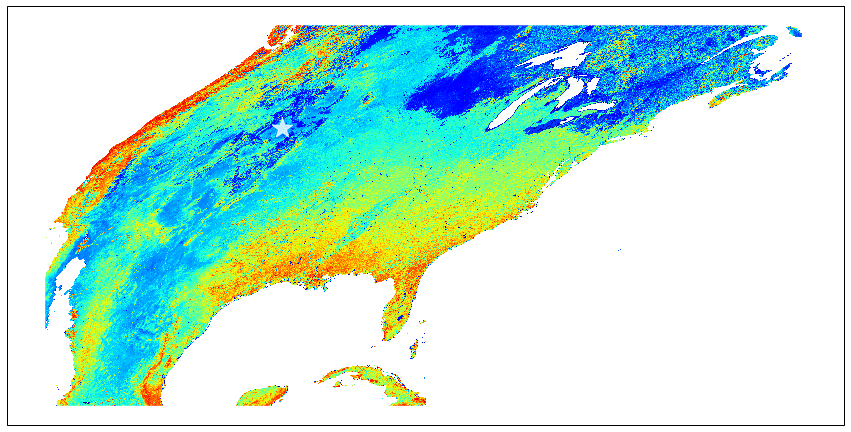

In [39]:
fig = plt.figure(figsize=(15, 15))
modis_proj = cartopy.crs.Sinusoidal.MODIS
ax = plt.axes(projection=modis_proj)


modis_mosaic_extents = [modis_mosaic.bounds.left, modis_mosaic.bounds.right, modis_mosaic.bounds.bottom, modis_mosaic.bounds.top]
ax.imshow(modis_mosaic_data[0, ::10, ::10], origin='upper', extent=modis_mosaic_extents, interpolation='none', 
          cmap=mpl.cm.jet, transform=modis_proj)
# ax.imshow(modis_mosaic_data[0, ::10, ::10], transform=modis_proj)

ax.scatter(site.x, site.y, color='white', s=450, alpha=0.8,  marker="*", transform=geodetic)

# ax.plot([ulx,lrx], [uly, uly], 'k-', lw=2, c='black', transform=landsat_proj)
# ax.plot([ulx,lrx], [lry, lry], 'k-', lw=2, c='black', transform=landsat_proj)
# ax.plot([ulx,ulx], [uly, lry], 'k-', lw=2, c='black', transform=landsat_proj)
# ax.plot([lrx,lrx], [uly, lry], 'k-', lw=2, c='black', transform=landsat_proj)
#love the modis sinusoidal grid!

# Extract out the cooresponding subset of modis pixels

In [40]:
modis_urx, modis_ury = list(modis_proj.transform_point(landsat_urx, landsat_ury, landsat_proj))
modis_llx, modis_lly = list(modis_proj.transform_point(landsat_llx, landsat_lly, landsat_proj))
modis_ulx, modis_uly = list(modis_proj.transform_point(landsat_ulx, landsat_uly, landsat_proj))
modis_lrx, modis_lry = list(modis_proj.transform_point(landsat_lrx, landsat_lry, landsat_proj))

print modis_urx, modis_ury
print modis_llx, modis_lly
print modis_ulx, modis_uly
print modis_lrx, modis_lry 

-9029104.49714 4669559.60585
-9046391.96209 4662082.58196
-9036511.19926 4669710.86617
-9038984.50807 4661931.68305


In [41]:
modis_a = modis_mosaic.affine

In [42]:
import math
modissubset_ll_col, modissubset_ll_row = [int(math.floor(coord)) for coord in ~modis_a * (modis_llx, modis_lly)]
modissubset_ur_col, modissubset_ur_row = [int(math.floor(coord)) for coord in ~modis_a * (modis_urx, modis_ury)]

print modissubset_ll_col, modissubset_ll_row
print modissubset_ur_col, modissubset_ur_row

8949 3875
9023 3842


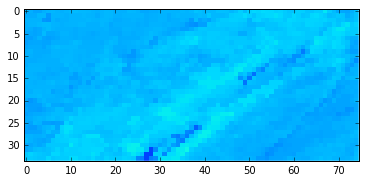

In [43]:
modis_subset = modis_mosaic_data[0, modissubset_ur_row:modissubset_ll_row+1, 
                                 modissubset_ll_col:modissubset_ur_col+1]

plt.imshow(modis_subset, interpolation='none', vmin=-2000, vmax=9149)

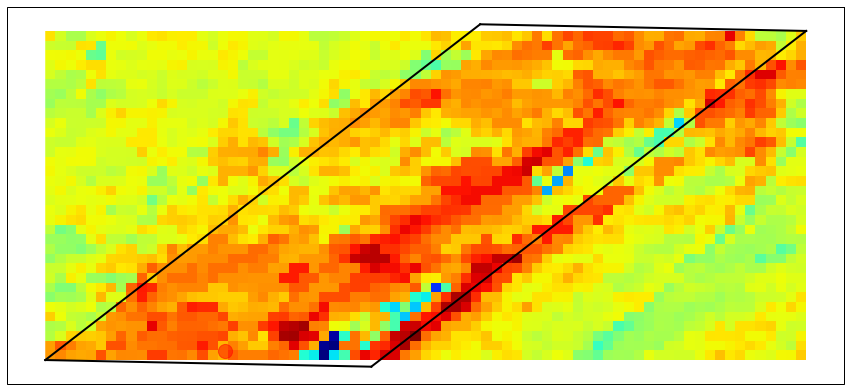

In [44]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
modis_proj = cartopy.crs.Sinusoidal.MODIS
ax = plt.axes(projection=modis_proj)

# elev_extents = [elev.bounds.left, elev.bounds.right, elev.bounds.bottom, elev.bounds.top]
mod_extents =  [modis_llx, modis_urx, modis_lly, modis_ury]
ax.imshow(modis_subset, origin='upper', extent=mod_extents, interpolation='none', 
          cmap=mpl.cm.jet, transform=modis_proj)

ax.scatter(site.x, site.y, color='r', s=200, alpha=0.5, transform=geodetic)

ax.plot([modis_ulx,modis_urx], [modis_uly, modis_ury], 'k-', lw=2, c='black', transform=modis_proj)
ax.plot([modis_urx,modis_lrx], [modis_ury, modis_lry], 'k-', lw=2, c='black', transform=modis_proj)
ax.plot([modis_lrx,modis_llx], [modis_lry, modis_lly], 'k-', lw=2, c='black', transform=modis_proj)
ax.plot([modis_llx,modis_ulx], [modis_lly, modis_uly], 'k-', lw=2, c='black', transform=modis_proj)

# ax.set_extent([ulx, lrx, lry, uly], landsat_proj)

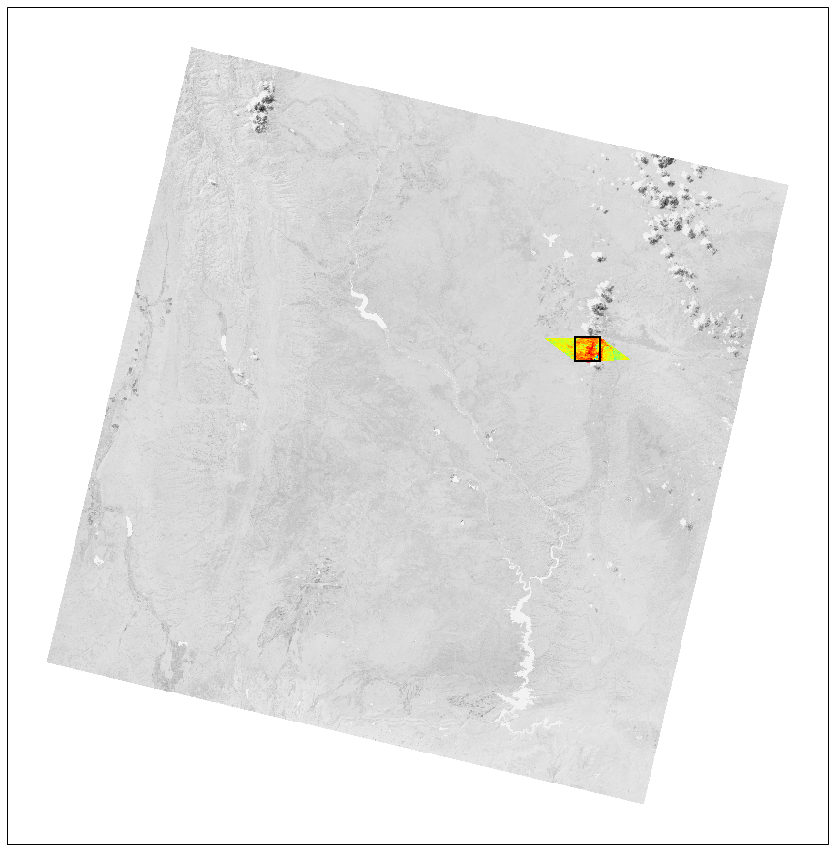

In [45]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=landsat_proj)
ax.imshow(landsat_data[0, ::10, ::10], origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.Greys)

mod_extents =  [modis_llx, modis_urx, modis_lly, modis_ury]
ax.imshow(modis_subset, origin='upper', extent=mod_extents, interpolation='none', 
          cmap=mpl.cm.jet, transform=modis_proj)

ax.scatter(site.x, site.y, color='r', s=20, alpha=0.5, transform=geodetic)

ax.plot([modis_ulx,modis_urx], [modis_uly, modis_ury], 'k-', lw=2, c='black', transform=modis_proj)
ax.plot([modis_urx,modis_lrx], [modis_ury, modis_lry], 'k-', lw=2, c='black', transform=modis_proj)
ax.plot([modis_lrx,modis_llx], [modis_lry, modis_lly], 'k-', lw=2, c='black', transform=modis_proj)
ax.plot([modis_llx,modis_ulx], [modis_lly, modis_uly], 'k-', lw=2, c='black', transform=modis_proj)


## Save out this subset as a tiff as well as the fishnet shapefile version

In [46]:
modis_dname = os.path.join(output_dir, 'MODIS', 'subset')
if not os.path.exists(modis_dname):
    os.makedirs(modis_dname)

In [47]:
modis_subset.shape[1]

75L

In [48]:
modis_subset_fname = os.path.join(modis_dname, "modis_subset.tif")

import copy
modis_subset_meta = copy.copy(modis_mosaic.meta)
modis_subset_meta['width'] = modis_subset.shape[1]
modis_subset_meta['height'] = modis_subset.shape[0]

snapped_ulx, snapped_uly = modis_a * (modissubset_ll_col, modissubset_ur_row)

new_transform = list(modis_mosaic.meta['transform'])
new_transform[0] = snapped_ulx
new_transform[3] = snapped_uly
modis_subset_meta['transform'] = tuple(new_transform)
import affine
modis_subset_meta['affine'] = affine.Affine.from_gdal(*modis_subset_meta['transform'])
with rasterio.open(modis_subset_fname, 'w', **modis_subset_meta) as dst:
    dst.write_band(1, modis_subset.astype(rasterio.int16))


In [49]:
from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry


snapped_ulx, snapped_uly = modis_a * (modissubset_ll_col, modissubset_ur_row)
snapped_lrx, snapped_lry = modis_a * (modissubset_ur_col+1, modissubset_ll_row+1)

poly = Polygon([(snapped_ulx, snapped_uly), (snapped_lrx, snapped_uly), 
                (snapped_lrx, snapped_lry), (snapped_ulx, snapped_lry), 
                (snapped_ulx, snapped_uly)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

modis_boundary_fname = os.path.join(modis_dname, 'modis_boundary.shp')
with fiona.open(modis_boundary_fname, 'w', 'ESRI Shapefile', schema, crs=modis_mosaic.crs) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(poly),
        'properties': {'id': 123},
    })

In [50]:
from shapely.geometry import mapping, Polygon
import fiona

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'row': 'int', 'col':'int'},
}

modis_fishnet_fname = os.path.join(modis_dname, 'modis_fishnet.shp')
with fiona.open(modis_fishnet_fname, 'w', 'ESRI Shapefile', schema, crs=modis_mosaic.crs) as c:
    ## If there are multiple geometries, put the "for" loop here
    for row in range(modis_subset.shape[0]):
        cell_uly = snapped_uly+(row*modis_a.e)
        for col in range(modis_subset.shape[1]):
            cell_ulx = snapped_ulx+(col*modis_a.a)
            poly = Polygon([(cell_ulx, cell_uly), 
                            (cell_ulx + modis_a.a, cell_uly), 
                            (cell_ulx + modis_a.a, cell_uly+modis_a.e), 
                            (cell_ulx, cell_uly+modis_a.e), 
                            (cell_ulx, cell_uly)])
    
    
            c.write({
                'geometry': mapping(poly),
                'properties': {'row': row,
                              'col':col},
            })

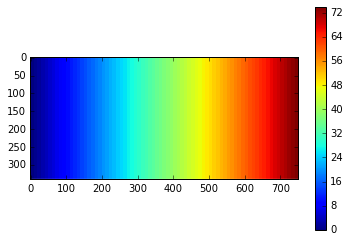

In [51]:
%matplotlib inline
n=10
r = np.zeros(modis_subset.shape).astype(np.dtype('i1'))
modis_col_x3 = np.tile(np.repeat(np.arange(r.shape[1]), n), (r.shape[0])*n)
modis_col_x3.shape = r.shape[0]*n, r.shape[1]*n

plt.imshow(modis_col_x3, interpolation='none')
plt.colorbar()


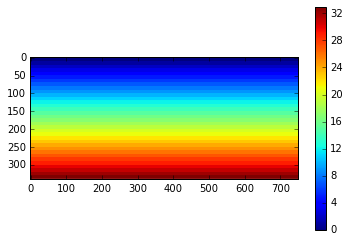

In [52]:
modis_row_x3 = np.tile(np.repeat(np.arange(r.shape[0]), n), (r.shape[1]*n))
modis_row_x3.shape = r.shape[1]*n, r.shape[0]*n
modis_row_x3 = modis_row_x3.T

plt.imshow(modis_row_x3, interpolation='none')
plt.colorbar()


In [53]:
modis_b = np.zeros(modis_row_x3.shape)

##### One small detail to note, because of the way ArcScene renders a raster, we're increasing the pixel  resoultion 10x

In [54]:
import scipy
modis_subset_index_fname = os.path.join(modis_dname, "modis_subset_index.tif")

import copy
modis_subset_meta = copy.copy(modis_mosaic.meta)
modis_subset_meta['width'] = modis_subset.shape[1] * n
modis_subset_meta['height'] = modis_subset.shape[0] * n

new_transform = list(modis_mosaic.meta['transform'])
modis_snapped_ulx, modis_snapped_uly = modis_a * (modissubset_ll_col, modissubset_ur_row)
new_transform[0] = modis_snapped_ulx
new_transform[3] = modis_snapped_uly
new_transform[1] = new_transform[1] / n
new_transform[-1] = new_transform[-1] / n
modis_subset_meta['transform'] = new_transform

import affine
modis_subset_meta['affine'] = affine.Affine.from_gdal(*modis_subset_meta['transform'])

modis_subset_meta.update(
    dtype=rasterio.uint8,
    count=3,
    nodata=255)

with rasterio.open(modis_subset_index_fname, 'w', **modis_subset_meta) as dst:
    dst.write_band(1, modis_col_x3.astype(rasterio.uint8))
    dst.write_band(2, modis_row_x3.astype(rasterio.uint8))
    dst.write_band(3, modis_b.astype(rasterio.uint8))

## Now we need to create the 3D representation of these data in ArcScene

#### 1 -- Open ArcScene, create a new document called ..\ArcScene\scene.sxd

#### 2 -- Add the following layers:

####  3 For each of them change the baseheights to be NED_30m.tif

#### 4-- Change the symbology as follows:

#### Now is the tricky/fidely part of recreating the phenocam image in ArcScene

### Now export the 4 2D images we'll use in the next steps.